<a href="https://colab.research.google.com/github/JN-Nataraj/ML-Linear_Regression-Kaggle_HousePrice_Prediction/blob/main/Notebook/Kaggle_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor

from datetime import datetime

from scipy.stats import f_oneway

from sklearn.linear_model import SGDRegressor

In [48]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.drop('Id', axis=1)
train.columns

current_year = datetime.now().year

Mean =  180921.19589041095
Median =  163000.0


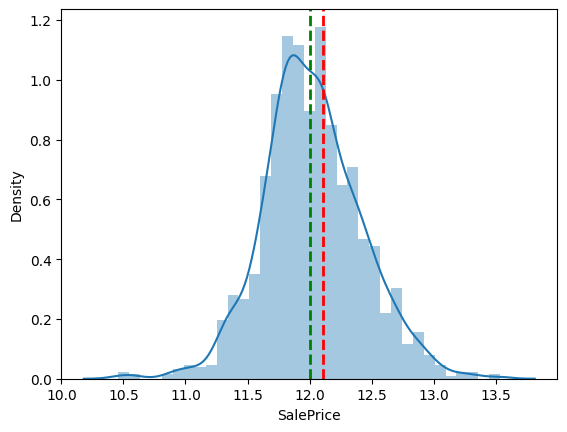

In [ ]:
# Check How House Price Value is Distributed
sns.distplot(np.log1p(train['SalePrice']))
#plot mean and median in distplot
plt.axvline(np.log1p(train['SalePrice'].mean()), color='red', linestyle='dashed', linewidth=2)
plt.axvline(np.log1p(train['SalePrice'].median()), color='green', linestyle='dashed', linewidth=2)

print("Mean = ",train['SalePrice'].mean())
print("Median = ",train['SalePrice'].median())

#Converting the house price to logarthimic
# train['SalePrice_log'] = np.log1p(train['SalePrice'])

In [56]:
#Check if there are any null values in features our training dataset
#train.info()
null_cols = train.columns[train.isnull().any()]
null_info = pd.DataFrame (
    {
        "Null Count" : train[null_cols].isnull().sum(),
        "Data Type"  : train[null_cols].dtypes
    }
)
null_info.sort_values(by='Null Count', ascending=False)

,Null Count,Data Type


In [49]:
train['SalePrice_log'] = np.log1p(train['SalePrice'])

for df in [train,test] :
    # Fixing all basement related data
    bsmt_cat_cols = ['BsmtCond','BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType2']
    for col in bsmt_cat_cols:
        df[col] = df[col].fillna('No Basement')
    # -------------- BASEMENT NUMERIC = 0 -----------------
    bsmt_num_cols = ['BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
    for col in bsmt_num_cols:
        df[col] = df[col].fillna(0)
    # Fixing Pool qualty Data by updating NA as No Pool
    df['PoolQC'] = df['PoolQC'].fillna('No Pool')
    # Fixing Alley Data by updating NA as No Alley Access
    df['Alley'] = df['Alley'].fillna('No Alley Access')
    # Fixing Fence Data by updating NA as No Fence
    df['Fence'] = df['Fence'].fillna('No Fence')
    # Fixing MasVnrType Data by updating NA & None  as No Veneer
    df['MasVnrType'] = df['MasVnrType'].fillna('No Veneer')
    # Fixing FireplaceQu Data by updating NA as No Veneer
    df['FireplaceQu'] = df['FireplaceQu'].fillna('No Fireplace')
    # Fixing GarageCond Data by updating NA as No Garage
    df['GarageCond'] = df['GarageCond'].fillna('No Garage')
    # Fixing GarageQual Data by updating NA as No Garage
    df['GarageQual'] = df['GarageQual'].fillna('No Garage')
    # Fixing GarageFinish Data by updating NA as No Garage
    df['GarageFinish'] = df['GarageFinish'].fillna('No Garage')
    # Fixing GarageType Data by updating NA as No Garage
    df['GarageType'] = df['GarageType'].fillna('No Garage')
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0) # Corrected: fill missing numerical values in GarageYrBlt
    # df['LotFrontage'] = df.groupby(['Condition1','Condition2','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    # df['LotFrontage'] = df.groupby(['Condition1','Condition2'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    # df['LotFrontage'] = df.groupby(['Condition1'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    # df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median()) # Final fill for any remaining NaNs
    #df[df['LotFrontage'].isnull()][['Condition1','Condition2','Neighborhood','LotFrontage']]
    #Introducing a new feature HasGarage to see in future if Grage is impacting the price
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x != 0 else 0) # Corrected: 0 if GarageArea is 0, else 1
    # Fixing MasVnrArea Data as we have some data where we have MasVnrType value
    # df['MasVnrArea'] = df.groupby(['MasVnrType'])['MasVnrArea'].transform(lambda x: x.fillna(x.median()))
    # df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median()) # Final fill for any remaining NaNs
    # Fixing Basement related values Data as we have TotalBsmtSF value, wherever it is 0 we can assume those properties does not have basement
    no_basement = df['TotalBsmtSF']==0
    basemt_categ_col = ['BsmtFinType2','BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1']
    for col in basemt_categ_col:
        df.loc[no_basement,col] = 'No Basement'
    has_basmnt = df['TotalBsmtSF']>0
    # Based on heat map could see a strong relationship between BsmtFinType2s BsmtCond when BsmtCond = TA,so updating null values with Unf where BsmtCond = TA
    df.loc[has_basmnt & (df['BsmtFinType2'].isnull()) & (df['BsmtCond']=='TA'),'BsmtFinType2'] = 'Unf'
    #has_basmnt = train['TotalBsmtSF']>0
    # Based on heat map could see a strong relationship between BsmtFinType2s BsmtCond when BsmtCond = TA,so updating null values with Unf where BsmtCond = TA
    df.loc[has_basmnt & (df['BsmtExposure'].isnull()) & (df['LandSlope']=='Gtl'),'BsmtExposure'] = 'No'
    #MasVnrArea we have two rows zer but it has type
    # median_values = df.groupby('MasVnrType')['MasVnrArea'].median()
    # mask = (df['MasVnrArea'] == 0) & (df['MasVnrType'] != 'None')
    # df.loc[mask, 'MasVnrArea'] = df.loc[mask, 'MasVnrType'].map(median_values)
    #Updating the 2nd floor squarefeet value
    df['2ndFlrSF'] = df['GrLivArea'] - df['1stFlrSF'] - df['LowQualFinSF']
    #Converting MsSubclass to category as it has unique values less than 20
    df['MSSubClass'] = df['MSSubClass'].astype('category')
    df['MoSold'] = df['MoSold'].astype('category')
    df['YrSold'] = df['YrSold'].astype('category')

    # Explicitly fill remaining NaNs in other columns
    # Fill Electrical NaNs with the mode
    if 'Electrical' in df.columns and df['Electrical'].isnull().any():
        df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    # Fill GarageCars and GarageArea NaNs with 0 (as these likely correspond to 'No Garage')
    if 'GarageCars' in df.columns and df['GarageCars'].isnull().any():
        df['GarageCars'] = df['GarageCars'].fillna(0)
    if 'GarageArea' in df.columns and df['GarageArea'].isnull().any():
        df['GarageArea'] = df['GarageArea'].fillna(0)

train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [52]:
# Use Train Value to Test Data
# -------------- CATEGORICAL MODE -----------------
mode_cols = ['MSZoning','Functional','Exterior1st','Exterior2nd','KitchenQual','SaleType']
for col in mode_cols:
    mode_value = train[col].mode()[0]     # fit only on train
    train[col] = train[col].fillna(mode_value)
    test[col]  = test[col].fillna(mode_value)

# -------------- FEATURE ENGINEERING NUMERIC = median -----------------
fe_median_cols = ['FE_Total_Bath_Score', 'FE_Total_squarefeet_log']
for col in fe_median_cols:
    median_val = train[col].median()
    train[col] = train[col].fillna(median_val)
    test[col]  = test[col].fillna(median_val)


In [50]:
# -------------------------------
# LOTFRONTAGE: Compute TRAIN medians
# -------------------------------

# Most specific median: Condition1 + Condition2 + Neighborhood
med_3 = train.groupby(['Condition1','Condition2','Neighborhood'])['LotFrontage'].median()
# Medium-level median: Condition1 + Condition2
med_2 = train.groupby(['Condition1','Condition2'])['LotFrontage'].median()
# Least specific median: Condition1
med_1 = train.groupby(['Condition1'])['LotFrontage'].median()
# Global fallback median
med_global = train['LotFrontage'].median()

# --- Try 3-column group median ---
mask = train['LotFrontage'].isna()
train.loc[mask, 'LotFrontage'] = [
    med_3.get((c1, c2, nbhd), np.nan)
    for c1, c2, nbhd in zip(train.loc[mask, 'Condition1'],
                            train.loc[mask, 'Condition2'],
                            train.loc[mask, 'Neighborhood'])
]
# --- Try 2-column group median ---
mask = train['LotFrontage'].isna()
train.loc[mask, 'LotFrontage'] = [
    med_2.get((c1, c2), np.nan)
    for c1, c2 in zip(train.loc[mask, 'Condition1'],
                      train.loc[mask, 'Condition2'])
]
# --- Try 1-column group median ---
mask = train['LotFrontage'].isna()
train.loc[mask, 'LotFrontage'] = [
    med_1.get(c1, np.nan)
    for c1 in train.loc[mask, 'Condition1']
]
# --- Final fallback ---
train['LotFrontage'] = train['LotFrontage'].fillna(med_global)

# --- Try 3-column group median ---
mask = test['LotFrontage'].isna()
test.loc[mask, 'LotFrontage'] = [
    med_3.get((c1, c2, nbhd), np.nan)
    for c1, c2, nbhd in zip(test.loc[mask, 'Condition1'],
                            test.loc[mask, 'Condition2'],
                            test.loc[mask, 'Neighborhood'])
]
# --- Try 2-column group median ---
mask = test['LotFrontage'].isna()
test.loc[mask, 'LotFrontage'] = [
    med_2.get((c1, c2), np.nan)
    for c1, c2 in zip(test.loc[mask, 'Condition1'],
                      test.loc[mask, 'Condition2'])
]
# --- Try 1-column group median ---
mask = test['LotFrontage'].isna()
test.loc[mask, 'LotFrontage'] = [
    med_1.get(c1, np.nan)
    for c1 in test.loc[mask, 'Condition1']
]
# --- Final fallback ---
test['LotFrontage'] = test['LotFrontage'].fillna(med_global)

mas_med = train.groupby('MasVnrType')['MasVnrArea'].median()
mas_global = train['MasVnrArea'].median()
# Fill NaN with train medians
train['MasVnrArea'] = train['MasVnrArea'].fillna(
    train['MasVnrType'].map(mas_med)
)
# Global fallback
train['MasVnrArea'] = train['MasVnrArea'].fillna(mas_global)
# Fix cases where MasVnrArea == 0 but MasVnrType has veneer
mask = (train['MasVnrArea'] == 0) & (train['MasVnrType'] != 'None') & (train['MasVnrType'] != 'No Veneer')
train.loc[mask, 'MasVnrArea'] = train.loc[mask, 'MasVnrType'].map(mas_med)

# Fill NaN using train mapping
test['MasVnrArea'] = test['MasVnrArea'].fillna(
    test['MasVnrType'].map(mas_med)
)
# Fallback to global
test['MasVnrArea'] = test['MasVnrArea'].fillna(mas_global)
# Fix zeros
mask = (test['MasVnrArea'] == 0) & (test['MasVnrType'] != 'None') & (test['MasVnrType'] != 'No Veneer')
test.loc[mask, 'MasVnrArea'] = test.loc[mask, 'MasVnrType'].map(mas_med)

### ***FEATURE ENGINEERING***


## ***NUMERICAL***



```
# Numerical values check for zero, if needs updation prepocess it
# num_cols = train.select_dtypes(include=['int64', 'float64']).columns
# zero_counts = (train[num_cols] == 0).sum()
# zero_df = pd.DataFrame({
#     'Zeros': (train[num_cols] == 0).sum(),
#     'Total Rows': len(train),
#     'Zero Percent': (train[num_cols] == 0).mean() * 100
# })

# zero_df = zero_df[zero_df['Zeros'] > 0].sort_values('Zero Percent', ascending=False)
# zero_df


# # train[['FE_Finished_BsmntSfRatio', 'SalePrice_log']].corr()

# # sns.scatterplot(x='LotFrontage', y='SalePrice', data=train)
# # plt.title("LotFrontage vs SalePrice")
# # plt.show()

# # Check How LotFrontage  Value is Distributed
# # sns.distplot(train['LotFrontage'])
# # #plot mean and median in distplot
## # plt.axvline(train['LotFrontage'].mean(), color='red', linestyle='dashed', linewidth=2)
# # plt.axvline(train['LotFrontage'].median(), color='green', linestyle='dashed', linewidth=2)

# corr = train.corr(numeric_only=True)
# important_mid_with_target = corr.index[corr['SalePrice_log'].abs() > 0.60]
# important_mid = corr.index[
#     (corr['SalePrice_log'].abs() > 0.30) &
#     (corr['SalePrice_log'].abs() < 0.40)
# ]
# important_mid_with_target = list(important_mid) + ['SalePrice_log']
# sns.heatmap(train[important_mid_with_target].corr(), annot=True, cmap='coolwarm')

# plt.figure(figsize=(10,4))
# sns.countplot(x=train['BsmtFinType2_After'])
# plt.title("After Imputation")
# plt.xticks(rotation=45)
# plt.show()
# train = train.drop(columns=['BsmtFinType2_before'], errors='ignore')
# train = train.drop(columns=['BsmtFinType2_after'], errors='ignore')
```



In [51]:
for df in [train,test] :
    # with BsmtFinSF1 & BsmtFinSF2 we can get a ratio of how much finished square feet % which could have a direct correlation -> Form a new feature
    df['FE_Finished_BsmntSfRatio'] = ((df['BsmtFinSF2'] + df['BsmtFinSF1']) / df['TotalBsmtSF']).replace([np.inf, np.nan],0)
    # converting LotArea_log to logarthimic as the distribution is right skewed
    df['FE_LotArea_log'] = np.log1p(df['LotArea'])
    # converting LotArea_log to logarthimic as the distribution is right skewed
    df['FE_LotFrontage_log'] = np.log1p(df['LotFrontage'])
    #Combining all the bathroom feature into single feature Engineering
    df['FE_Total_Bath_Score'] = (df['HalfBath']*0.5 + df['FullBath']*1 + df['BsmtFullBath']*1 + df['BsmtHalfBath']*0.5)
    #Combining total square feet (GrLivArea + TotalBsmtSF)
    df['FE_Total_squarefeet_log'] = np.log1p(df['GrLivArea'] + df['TotalBsmtSF'])
    #Found the building age
    df['FE_Buildin_Age'] = current_year - df['YearBuilt'] # Corrected: Use df['YearBuilt'] instead of train['YearBuilt']
    #Found the year since remodelling
    df['FE_YearSinceRemodel'] = current_year - df['YearRemodAdd'] # Corrected: Use df['YearRemodAdd'] instead of train['YearRemodAdd']

### ***CATEGORICAL***

```
cat_cols = train.select_dtypes(include=['object', 'category']).columns

anova_results = []

for col in cat_cols:
    groups = [g['SalePrice_log'].values
              for _, g in train.groupby(col)]
    try:
        f_stat, p_value = f_oneway(*groups)
        anova_results.append((col, p_value))
    except:
        anova_results.append((col, None))

anova_df = pd.DataFrame(anova_results, columns=['Feature', 'p_value'])

# Sort by p-value (smallest = most significant)
anova_df = anova_df.sort_values(by='p_value')

anova_df



# plt.figure(figsize=(10,5))
# sns.countplot(data=train, x='MSSubClass')
# plt.xticks(rotation=45)
# plt.title('Distribution of MSSubClass')
# plt.show()




# sns.boxplot(x='MSSubClass', y='SalePrice_log', data=train)
# plt.xticks(rotation=45)



num_cols = train.select_dtypes(include=['int64', 'float64']).columns
num_cat_cols = [col for col in num_cols if train[col].nunique() < 20]
num_cat_cols
```



In [54]:
#Droping numerical columns which does not have strong predictive power
for df in [train,test] :
    #Pool Area can be ignored with zero values as for its respective pool quality is No Pool
    #Ignore PoolArea
    #Ignore 3SsnPorch
    # df.drop(columns=['PoolArea'], errors='ignore',inplace=True)
    # df.drop(columns=['3SsnPorch'], errors='ignore',inplace=True)
    # #df.drop(columns=['LowQualFinSF'], errors='ignore',inplace=True)
    # df.drop(columns=['MiscVal'], errors='ignore',inplace=True)
    df.drop(columns=['MiscFeature'], errors='ignore',inplace=True) # As only 54 properties has this feature, so better to avoid it from prediction
    # df.drop(columns=['ScreenPorch'], errors='ignore',inplace=True) # As more than 80% of value is 0
    # df.drop(columns=['BsmtUnfSF'], errors='ignore',inplace=True) # As the co-relation with sales price not much high
    # df.drop(columns=['EnclosedPorch'], errors='ignore',inplace=True) # Has negative cor-relation and most of the values is zer0
    # df.drop(columns=['HalfBath'], errors='ignore',inplace=True) # Have combined to form a new feature value
    # df.drop(columns=['FullBath'], errors='ignore',inplace=True) # Have combined to form a new feature value
    df.drop(columns=['BsmtFullBath'], errors='ignore',inplace=True) # Have combined to form a new feature value
    df.drop(columns=['Utilities'], errors='ignore',inplace=True) # Have combined to form a new feature value


In [57]:
# Finalizing The Features And Targets
target_log = "SalePrice_log"
target = "SalePrice"
features = ['MSSubClass','MSZoning','Alley','LotShape','LandContour','LotConfig','Neighborhood','Condition1',
            'BldgType','HouseStyle','OverallQual','RoofStyle','Exterior1st','Exterior2nd','MasVnrType',
            'MasVnrArea','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','TotRmsAbvGrd','Functional',
            'FireplaceQu','GarageType','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond','PavedDrive',
            'WoodDeckSF','OpenPorchSF','PoolQC','Fence','SaleType','SaleCondition','FE_Finished_BsmntSfRatio',
            'FE_LotArea_log','FE_LotFrontage_log','FE_Total_Bath_Score','FE_Total_squarefeet_log','FE_Buildin_Age','FE_YearSinceRemodel']
X = train[features]
X_test = test[features]
y_log = train[target_log]
y = train[target]
num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

### ***MODEL : LINEAR REGRESSION***

In [58]:
# Model Training
preprocessor = ColumnTransformer([("num",StandardScaler(),num_cols),
                                  ("cat", OneHotEncoder(handle_unknown="ignore", drop='first',sparse_output=False),cat_cols)])
lin_pipe = Pipeline([('prep',preprocessor),
                     ('model',LinearRegression())])
lin_pipe.fit(X,y_log)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['OverallQual', 'MasVnrArea', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'FE_Finished_BsmntSfRatio',
       'FE_LotArea_log', 'FE_LotFrontage_log', 'FE_Total_Bath_Score',
       'FE_Total_squarefeet_log', 'FE_Buildin_Age', 'FE_YearSinceRemodel'],
      dtype='object')...
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model', LinearRegression())])

### ***TRAINING PREDICTION***

In [59]:
y_linear_pred = lin_pipe.predict(X)

r2 = r2_score(y_log,y_linear_pred)
print(f"Linear R2 Score : {r2}")

rmse = np.sqrt(mean_squared_error(y_log,y_linear_pred))
print(f"Linear RMSE : {rmse}")

Linear R2 Score : 0.9302714516443079
Linear RMSE : 0.10544309996757291


### ***TESTING PREDICTION***

In [63]:
y_test_linear_pred = lin_pipe.predict(X_test)
preds = np.clip(y_test_linear_pred,0,None)

submission = pd.DataFrame({'Id':test['Id'],
                           'SalePrice': np.expm1(y_test_linear_pred)})

submission.to_csv("Submission_LR_Predict.csv",index=False)

### ***MODEL : SGDREGRESSOR***

In [82]:
preprocessor = ColumnTransformer([("num",StandardScaler(),num_cols),
                                  ("cat", OneHotEncoder(handle_unknown="ignore", drop='first',sparse_output=False),cat_cols)])
sgd_pipe = Pipeline([('prep',preprocessor),
                     ('model',SGDRegressor())])
sgd_pipe.fit(X,y_log)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['OverallQual', 'MasVnrArea', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'FE_Finished_BsmntSfRatio',
       'FE_LotArea_log', 'FE_LotFrontage_log', 'FE_Total_Bath_Score',
       'FE_Total_squarefeet_log', 'FE_Buildin_Age', 'FE_YearSinceRemodel'],
      dtype='object')...
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model', SGDRegressor())])

### ***TRAINING PREDICTION***

In [83]:
y_sgdReg_pred = sgd_pipe.predict(X)

r2 = r2_score(y_log,y_sgdReg_pred)
print(f"Linear R2 Score : {r2}")

rmse = np.sqrt(mean_squared_error(y_log,y_sgdReg_pred))
print(f"Linear RMSE : {rmse}")

Linear R2 Score : 0.4299857790973056
Linear RMSE : 0.301478050910928
